# **Modelling and Evaluating**

## Objectives

* Answer business requirement 2: The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry_tree_dataset/cherry-leaves/test
* inputs/cherry_tree_dataset/cherry-leaves/train
* inputs/cherry_tree_dataset/cherry-leaves/validation

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.


## Additional Comments

* No comments 



---

## Import libraries required

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set the working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-in-cherry-trees')
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-in-cherry-trees'

### Set input directory

Set the train, test and validation paths.

In [5]:
my_data_dir = 'inputs/cherry_tree_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [7]:
# Set the labels
labels = os.listdir(train_path)
print(f"Project Labels: {labels}")

Project Labels: ['healthy', 'powdery_mildew']


### Set Image shape

In [9]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Image distribution

#### Count number of images per set and label

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




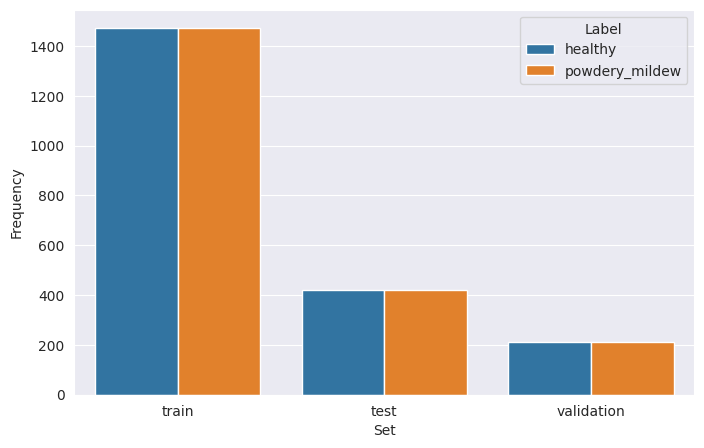

In [14]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Set distribution Pie Chart

In [ ]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)

px = 1/plt.rcParams['figure.dpi'] 
plt.subplots(figsize=(800*px, 250*px))
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Data Visualization

### Data cleaning

Check and remove any non image files

---

# Conclusion and next steps

### Conclusion

* The outcome of this notebook was to obtain the data from Kaggle, check for any non image files, remove them if necessary and split the data between train, test and validation.

* The data set contained 4208 images of leaves. Evenly split in the middle, healthy and not healthy.

* The data was then split into test, train and validation. 70% train, 10% validation and 20% test.

### The next steps

* The next notebook will contain the data visulaization part. Focussing on the first business requirement - The client is interested in being able to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.